In [69]:
import pandas as pd
import matplotlib.pyplot as plt

all_data = pd.read_csv('data.csv')
all_data = all_data.iloc[::-1].reset_index(drop=True)
# Reset the 'No' column to match the new row order (0 to len-1)
all_data['No'] = range(len(all_data))

# Data Viz

In [70]:
# Display column names
print("Column Names:")
print(list(all_data.columns))
print("\n" + "="*80 + "\n")

# Display first few rows
print("Sample Data:")
print(all_data.head(3))
print("\n...")
print(f"\n[{len(all_data)} total rows]")
# all_data['No'] = all_data['No'] - 295

Column Names:
['No', 'Date', 'Natural_Gas', 'Natural_Gas_Vol.', 'Crude_oil', 'Crude_oil_Vol.', 'Copper', 'Copper_Vol.', 'Bitcoin', 'Bitcoin_Vol.', 'Ethereum', 'Ethereum_Vol.', 'S&P_500', 'Nasdaq_100_Price', 'Nasdaq_100_Vol.', 'Apple', 'Apple_Vol.', 'Tesla', 'Tesla_Vol.', 'Microsoft', 'Microsoft_Vol.', 'Silver', 'Silver_Vol.', 'Google', 'Google_Vol.', 'Nvidia', 'Nvidia_Vol.', 'Berkshire', 'Berkshire_Vol.', 'Netflix', 'Netflix_Vol.', 'Amazon', 'Amazon_Vol.', 'Meta', 'Meta_Vol.', 'Gold', 'Gold_Vol.']


Sample Data:
   No      Date  Natural_Gas  Natural_Gas_Vol.  Crude_oil  Crude_oil_Vol.  \
0   0  2/1/2020        2.122            164570      61.18          486870   
1   1  3/1/2020        2.130            144670      63.05          885860   
2   2  6/1/2020        2.135            154680      63.27          724240   

   Copper  Copper_Vol.  Bitcoin  Bitcoin_Vol.  ...  Berkshire  Berkshire_Vol.  \
0   2.825        72460     6967        632780  ...     342261             410   
1   2.787  

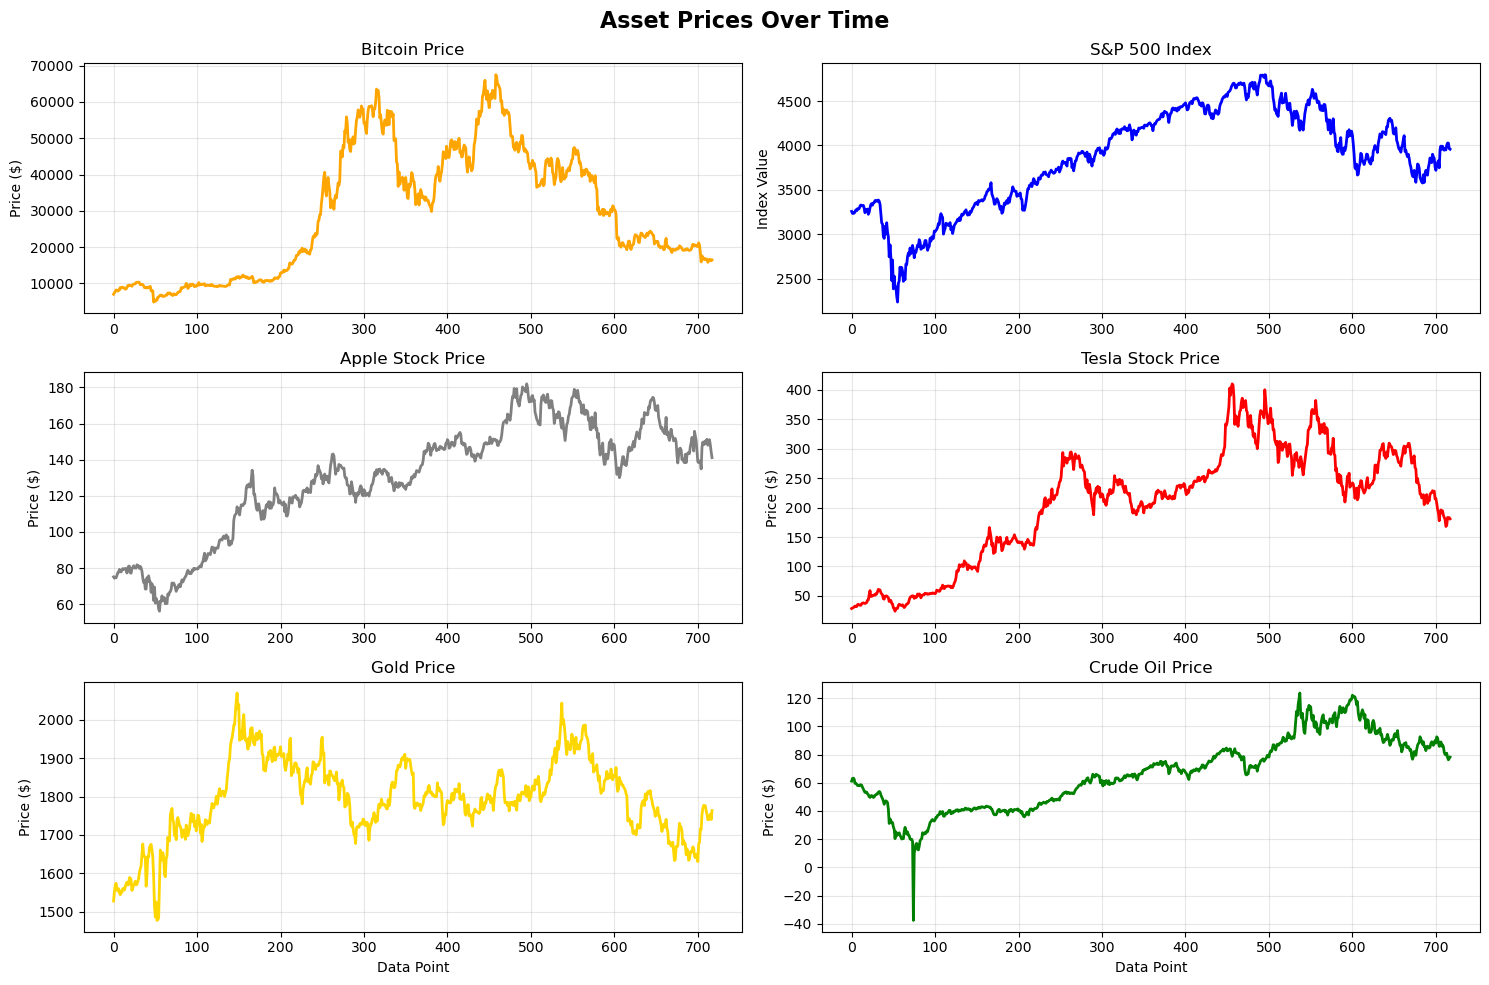

In [71]:
# Plot key assets over time
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Asset Prices Over Time', fontsize=16, fontweight='bold')

# Bitcoin
axes[0, 0].plot(all_data['No'], all_data['Bitcoin'], color='orange', linewidth=2)
axes[0, 0].set_title('Bitcoin Price')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# S&P 500
axes[0, 1].plot(all_data['No'], all_data['S&P_500'], color='blue', linewidth=2)
axes[0, 1].set_title('S&P 500 Index')
axes[0, 1].set_ylabel('Index Value')
axes[0, 1].grid(True, alpha=0.3)

# Apple
axes[1, 0].plot(all_data['No'], all_data['Apple'], color='gray', linewidth=2)
axes[1, 0].set_title('Apple Stock Price')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].grid(True, alpha=0.3)

# Tesla
axes[1, 1].plot(all_data['No'], all_data['Tesla'], color='red', linewidth=2)
axes[1, 1].set_title('Tesla Stock Price')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].grid(True, alpha=0.3)

# Gold
axes[2, 0].plot(all_data['No'], all_data['Gold'], color='gold', linewidth=2)
axes[2, 0].set_title('Gold Price')
axes[2, 0].set_xlabel('Data Point')
axes[2, 0].set_ylabel('Price ($)')
axes[2, 0].grid(True, alpha=0.3)

# Crude Oil
axes[2, 1].plot(all_data['No'], all_data['Crude_oil'], color='green', linewidth=2)
axes[2, 1].set_title('Crude Oil Price')
axes[2, 1].set_xlabel('Data Point')
axes[2, 1].set_ylabel('Price ($)')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("progress_report/media/asset_price.pdf")

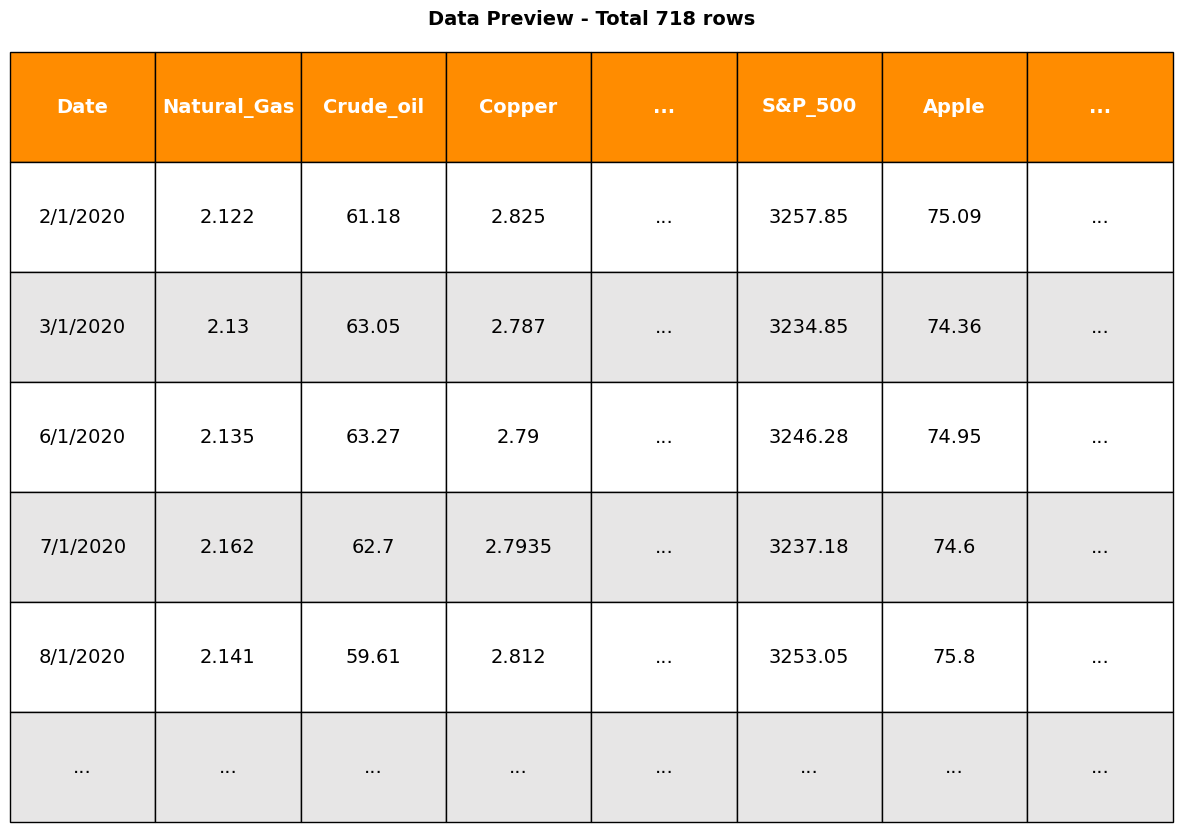

In [78]:
# Visualize data in table format (Excel-like) - selected columns only
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.axis('tight')
ax.axis('off')

# Select specific columns to display
selected_cols = ['Date', 'Natural_Gas', 'Crude_oil', 'Copper', '...', 'S&P_500', 'Apple', '...']

# Get data for selected columns (skip '...' placeholders)
table_data = [selected_cols]  # Header row

# Get first 5 data rows
for idx in range(5):
    row = []
    row.append(all_data.iloc[idx]['Date'])
    row.append(all_data.iloc[idx]['Natural_Gas'])
    row.append(all_data.iloc[idx]['Crude_oil'])
    row.append(all_data.iloc[idx]['Copper'])
    row.append('...')
    row.append(all_data.iloc[idx]['S&P_500'])
    row.append(all_data.iloc[idx]['Apple'])
    row.append('...')
    table_data.append(row)

# Add final row with dots
table_data.append(['...'] * len(selected_cols))

# Create table
table = ax.table(cellText=table_data, 
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2.5)

# Make header row bold and with different color
for i in range(len(selected_cols)):
    cell = table[(0, i)]
    cell.set_facecolor('#FF8C00')
    cell.set_text_props(weight='bold', color='white')

# Alternate row colors for data rows
for i in range(1, len(table_data)):
    for j in range(len(selected_cols)):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E7E6E6')
        else:
            cell.set_facecolor('#FFFFFF')

plt.title(f'Data Preview - Total {len(all_data)} rows', 
          fontsize=14, fontweight='bold', pad=20)
plt.savefig("progress_report/media/data_preview.pdf")

# Data Preprocessing 
Here we do:
- Log return of the data
- why pick Autocorrelation analysis for lag parameter selection
- perform PCA to select most important features
- Sliding window to create sequences for time series modeling


In [73]:
# STEP 1: Split data into alternating train/test segments
# Pattern: 287 train -> 72 test -> 287 train -> 72 test
# This creates 2 train segments and 2 test segments

import numpy as np

price_vol_columns = [
    'Natural_Gas', 'Crude_oil', 'Copper', 'Bitcoin', 'Ethereum', 
    'S&P_500', 'Nasdaq_100_Price', 'Apple', 'Tesla', 'Microsoft', 
    'Silver', 'Google', 'Nvidia', 'Berkshire', 'Netflix', 
    'Amazon', 'Meta', 'Gold'
]

# Define segment sizes
train_segment_size = 287
test_segment_size = 72

# Helper function to calculate log returns
def calculate_log_returns(data, price_columns):
    """Calculate log returns for a dataset"""
    log_ret = pd.DataFrame()
    log_ret['No'] = data['No'].values
    log_ret['Date'] = data['Date'].values
    
    for col in price_columns:
        # Calculate log returns
        log_ret[f'{col}_LogReturn'] = np.log(data[col] / data[col].shift(1))
    
    # Drop first row (NaN from shift)
    log_ret = log_ret.iloc[1:].reset_index(drop=True)
    return log_ret

# Split into segments
# Segment 1: train [0:287]
train_seg_1_raw = all_data.iloc[0:train_segment_size].copy()
# Segment 2: test [287:359]
test_seg_1_raw = all_data.iloc[train_segment_size:train_segment_size + test_segment_size].copy()
# Segment 3: train [359:646]
train_seg_2_raw = all_data.iloc[train_segment_size + test_segment_size:2*train_segment_size + test_segment_size].copy()
# Segment 4: test [646:718]
test_seg_2_raw = all_data.iloc[2*train_segment_size + test_segment_size:2*train_segment_size + 2*test_segment_size].copy()

print("Raw Data Split (Alternating Segments):")
print("="*60)
print(f"Train segment 1: rows 0-{train_segment_size-1} ({len(train_seg_1_raw)} rows)")
print(f"Test segment 1: rows {train_segment_size}-{train_segment_size + test_segment_size - 1} ({len(test_seg_1_raw)} rows)")
print(f"Train segment 2: rows {train_segment_size + test_segment_size}-{2*train_segment_size + test_segment_size - 1} ({len(train_seg_2_raw)} rows)")
print(f"Test segment 2: rows {2*train_segment_size + test_segment_size}-{2*train_segment_size + 2*test_segment_size - 1} ({len(test_seg_2_raw)} rows)")

# STEP 2: Calculate log returns for each segment separately
train_seg_1_traj = calculate_log_returns(train_seg_1_raw, price_vol_columns)
test_seg_1_traj = calculate_log_returns(test_seg_1_raw, price_vol_columns)
train_seg_2_traj = calculate_log_returns(train_seg_2_raw, price_vol_columns)
test_seg_2_traj = calculate_log_returns(test_seg_2_raw, price_vol_columns)

print("\nLog Returns After Calculation (each segment processed independently):")
print("="*60)
print(f"Train segment 1: {len(train_seg_1_traj)} rows")
print(f"Test segment 1: {len(test_seg_1_traj)} rows")
print(f"Train segment 2: {len(train_seg_2_traj)} rows")
print(f"Test segment 2: {len(test_seg_2_traj)} rows")

# STEP 3: Concatenate segments for training and testing
train_traj = pd.concat([train_seg_1_traj, train_seg_2_traj], axis=0, ignore_index=True)
test_traj = pd.concat([test_seg_1_traj, test_seg_2_traj], axis=0, ignore_index=True)

print("\nFinal Concatenated Data:")
print("="*60)
print(f"Train traj (concatenated): {len(train_traj)} rows")
print(f"Test traj (concatenated): {len(test_traj)} rows")

# Create combined log returns for visualization only
log_returns = pd.DataFrame()
log_returns['No'] = all_data['No']
log_returns['Date'] = all_data['Date']
for col in price_vol_columns:
    log_returns[f'{col}_LogReturn'] = np.log(all_data[col] / all_data[col].shift(1))

print(f"\nCombined log returns (for viz only): {log_returns.shape}")


Raw Data Split (Alternating Segments):
Train segment 1: rows 0-286 (287 rows)
Test segment 1: rows 287-358 (72 rows)
Train segment 2: rows 359-645 (287 rows)
Test segment 2: rows 646-717 (72 rows)

Log Returns After Calculation (each segment processed independently):
Train segment 1: 286 rows
Test segment 1: 71 rows
Train segment 2: 286 rows
Test segment 2: 71 rows

Final Concatenated Data:
Train traj (concatenated): 572 rows
Test traj (concatenated): 142 rows

Combined log returns (for viz only): (718, 20)


/opt/miniconda3/envs/dsml/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda3/envs/dsml/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


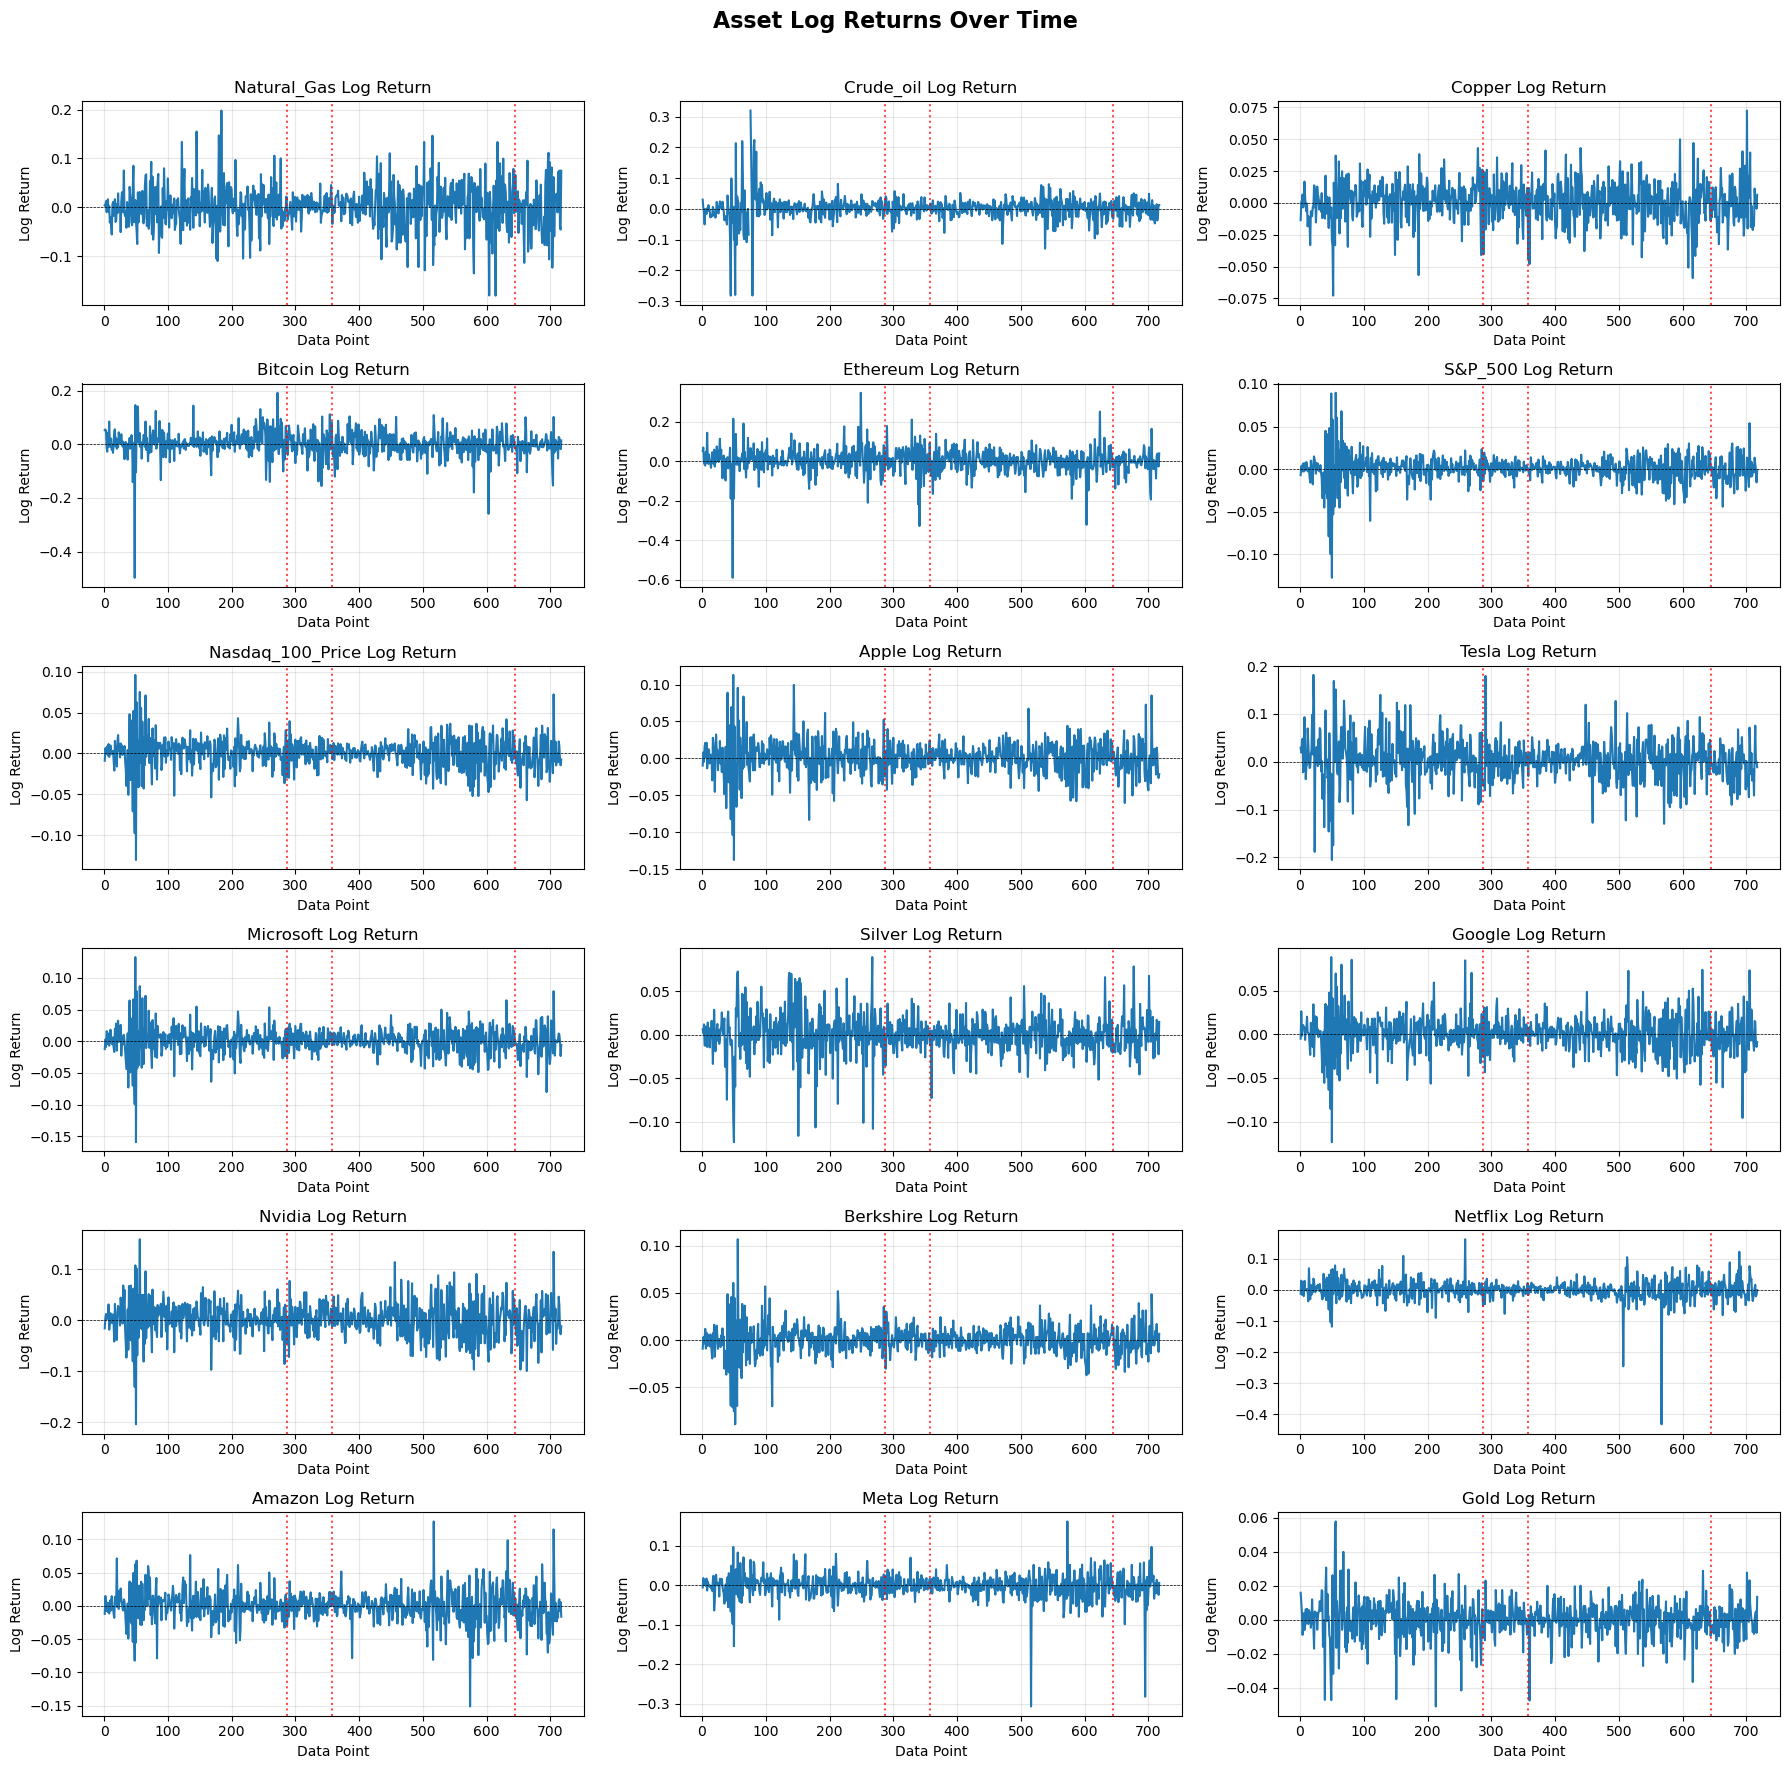

In [74]:
import math
import matplotlib.pyplot as plt

# Define list of asset names
price_vol_columns = [
    'Natural_Gas', 'Crude_oil', 'Copper', 'Bitcoin', 'Ethereum', 
    'S&P_500', 'Nasdaq_100_Price', 'Apple', 'Tesla', 'Microsoft', 
    'Silver', 'Google', 'Nvidia', 'Berkshire', 'Netflix', 
    'Amazon', 'Meta', 'Gold'
]

# Calculate grid size for subplots
n_assets = len(price_vol_columns)
n_cols = 3  # Number of columns per row
n_rows = math.ceil(n_assets / n_cols)

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3))
fig.suptitle('Asset Log Returns Over Time', fontsize=16, fontweight='bold')

# Flatten axes array for easy iteration
axes = axes.flatten()

# Define segment boundaries
segment_boundaries = [287, 358, 645]

# Plot each asset
for i, asset in enumerate(price_vol_columns):
    col_name = f'{asset}_LogReturn'
    axes[i].plot(log_returns['No'], log_returns[col_name], linewidth=1.5)
    axes[i].set_title(f'{asset} Log Return')
    axes[i].set_ylabel('Log Return')
    axes[i].set_xlabel('Data Point')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    
    # Add vertical dotted lines at segment boundaries
    for boundary in segment_boundaries:
        axes[i].axvline(x=boundary, color='red', linestyle=':', linewidth=1.5, alpha=0.7)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("progress_report/media/all_asset_log_returns.pdf")
plt.show()


In [75]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

target_col = 'S&P_500_LogReturn'
feature_cols = [col for col in log_returns.columns if col.endswith('_LogReturn') and col != target_col]

log_returns_clean = log_returns.dropna()
features_only = log_returns_clean[feature_cols]
X = log_returns_clean[feature_cols].values

# print(f"gan{len(features_only)}")

lag_size = 70

print(X.shape)
print(X)

import numpy as np
print(features_only)
voting_score_PCA = np.zeros(17)

lag_i = 0
while True:
    if lag_i + lag_size > X.shape[0]:
        break
    print(X[lag_i:lag_i+lag_size,:].shape)
    X_lag = X[lag_i:lag_i+lag_size,:]
    
    
    # PCA with n=6
    pca = PCA(n_components=10)
    pca.fit(X_lag)
    
    # Get feature names
    feature_names = [col.replace('_LogReturn', '') for col in feature_cols]
    
    # Print top 6 components
    print(f"Lag window {lag_i}-{lag_i+lag_size-1}:")
    for i in range(10):
        loadings = np.abs(pca.components_[i])
        top_idx = np.argmax(loadings)
        print(f"  PC{i+1}: {feature_names[top_idx]} ({pca.explained_variance_ratio_[i]:.3f})")
        voting_score_PCA[top_idx] = 10 * 1/(i+1) + voting_score_PCA[top_idx]
    
    lag_i = lag_i + lag_size

print(feature_names)
print(voting_score_PCA)
    
    
    


(715, 17)
[[ 0.00376294  0.03010772 -0.01354262 ... -0.01219204 -0.00530531
   0.01577699]
 [ 0.00234467  0.00348322  0.00107585 ...  0.01471783  0.01865841
   0.01050888]
 [ 0.01256707 -0.00904984  0.00125369 ...  0.00209996  0.00216135
   0.00349973]
 ...
 [-0.03963678 -0.02152852  0.00358473 ... -0.0076784  -0.00742235
   0.00480056]
 [-0.04543589  0.01250668 -0.00455205 ...  0.00576432 -0.0238896
  -0.00784138]
 [ 0.07503339  0.01235219  0.0063396  ... -0.01641932  0.00623169
   0.01335636]]
     Natural_Gas_LogReturn  Crude_oil_LogReturn  Copper_LogReturn  \
1                 0.003763             0.030108         -0.013543   
2                 0.002345             0.003483          0.001076   
3                 0.012567            -0.009050          0.001254   
4                -0.009761            -0.050538          0.006601   
5                 0.011609            -0.000839         -0.003563   
..                     ...                  ...               ...   
713             

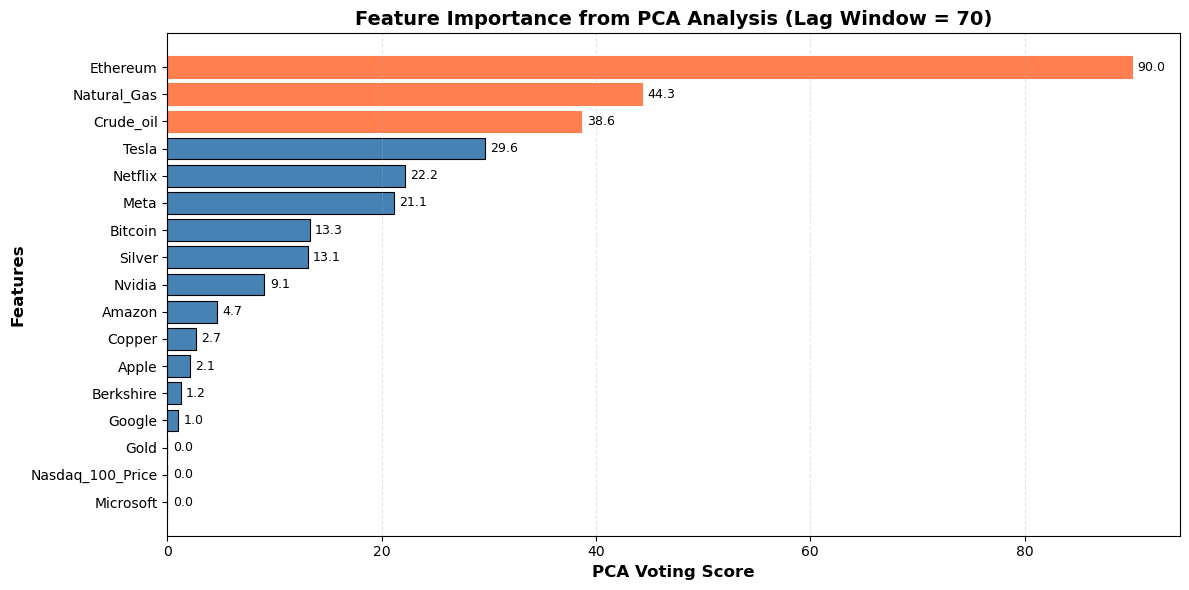

In [76]:
import matplotlib.pyplot as plt

# Sort features by voting score
sorted_indices = np.argsort(voting_score_PCA)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_scores = voting_score_PCA[sorted_indices]

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(sorted_features, sorted_scores, color='steelblue', edgecolor='black', linewidth=0.8)

# Highlight top 3 features
for i in range(min(3, len(bars))):
    bars[i].set_color('coral')

ax.set_xlabel('PCA Voting Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance from PCA Analysis (Lag Window = 70)', fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()

# Add value labels on bars
for i, (feature, score) in enumerate(zip(sorted_features, sorted_scores)):
    ax.text(score + 0.5, i, f'{score:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig("progress_report/media/pca_feature_importance.pdf")
plt.show()

# Training

In [77]:
# Loop through each segment and print feature matrix sizes

print("="*60)
print("FEATURE MATRICES FOR EACH SEGMENT")
print("="*60)

segments = {
    'Train Segment 1': train_seg_1_traj,
    'Test Segment 1': test_seg_1_traj,
    'Train Segment 2': train_seg_2_traj,
    'Test Segment 2': test_seg_2_traj
}

for seg_name, seg_data in segments.items():
    print(f"\n{seg_name}:")
    print(f"  Data shape: {seg_data.shape}")

print("\n" + "="*60)


FEATURE MATRICES FOR EACH SEGMENT

Train Segment 1:
  Data shape: (286, 20)

Test Segment 1:
  Data shape: (71, 20)

Train Segment 2:
  Data shape: (286, 20)

Test Segment 2:
  Data shape: (71, 20)

